#### 利用Docker与FastAPI部署机器学习模型

构建和部署机器学习模型所设计到的步骤通常可以总结为：模型构建、创建API来提供模型预测、容器化API以及部署到云端. 有关相关环境配置问题，可以阅读[基于WSL2+Docker+VScode搭建机器学习(深度学习)开发环境](https://blog.csdn.net/AIHUBEI/article/details/134619653?spm=1001.2014.3001.5502).

这个记事本主要内容如下：

* 使用Scikit-learn构建机器学习模型;
* 使用FastAPI创建REST API来提供模型预测；
* 使用Docker容器化API；

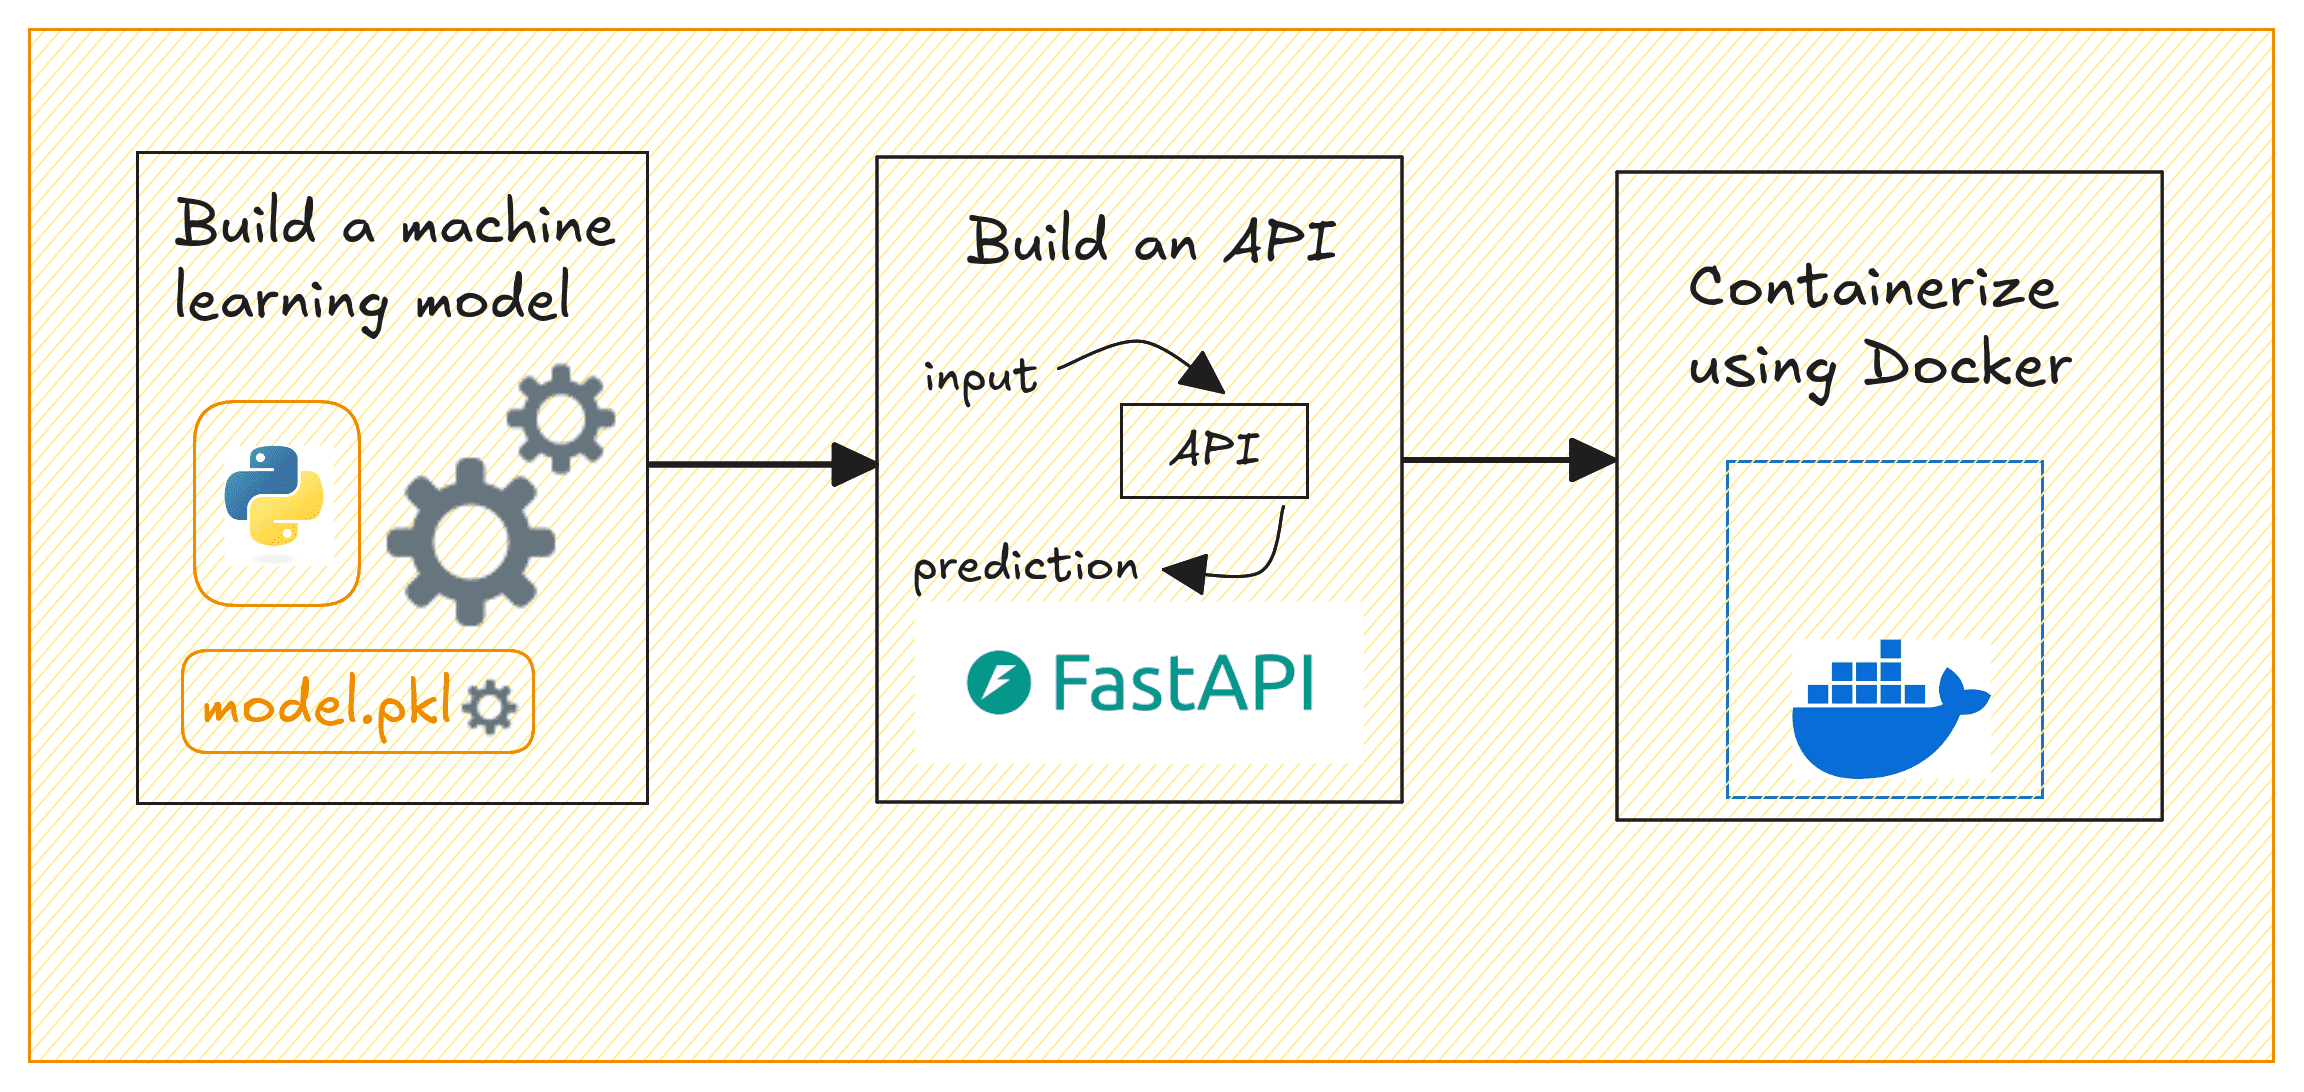

In [19]:
from IPython.display import Image

Image(filename='./Appendix-files/figures/model-deployment.png', width=550)

In [2]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple pandas scikit-learn fastapi uvicorn matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


#### 机器学习模型创建

这里以混凝土抗压强度预测为例，创建一个机器学习模型.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
%pwd

'/media/xy/文件/Code_folder/machine_learning/Useful-Python-Scripts/Scripts_folder/ML-利用Docker与FastAPI部署机器学习模型'

In [5]:
# 数据读取.
df = pd.read_csv('../../Datasets/混凝土抗压强度预测/concrete_data.csv')
print("DF shape:", df.shape)
df.tail()

DF shape: (1030, 9)


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.40


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
Blast Furnace Slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
Fly Ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
Superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
Coarse Aggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
Fine Aggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
Age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
Strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [7]:
# 打印所有的列名.
print(list(df.columns))

['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength']


In [8]:
# 避免字段中的空格，以防各种问题.
df.columns = ['Cement', 'Blast_Furnace_Slag', 'Fly_Ash', 'Water', 'Superplasticizer', 'Coarse_Aggregate', 'Fine_Aggregate', 'Age', 'Strength']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast_Furnace_Slag  1030 non-null   float64
 2   Fly_Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse_Aggregate    1030 non-null   float64
 6   Fine_Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [10]:
# 异常值处理.
def remove_outliers(df, col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    df[col_name] = df[col_name].apply(lambda x: Q1-1.5*IQR if x < (Q1-1.5*IQR) else (Q3+1.5*IQR if x > (Q3+1.5*IQR) else x))

    return df

In [11]:
for col in df.select_dtypes(exclude='object').columns[:-1]:
    df = remove_outliers(df, col)

In [12]:
# 训练集与测试集划分.
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [13]:
# 标准化处理.
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [14]:
# 模型训练与评估.
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R2 Score:", r2_score(y_test, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print("Root Mean Squared Error:", root_mean_squared_error(y_test, y_pred))
    return model

In [15]:
# 线性回归.
from sklearn.linear_model import LinearRegression

model_train(LinearRegression(), X_train, X_test, y_train, y_test)

R2 Score: 0.657866786997239
Mean Absolute Error: 7.385149849022979
Root Mean Squared Error: 9.444166145857883


LinearRegression()

In [16]:
# 随机森林.
from sklearn.ensemble import RandomForestRegressor
RF_model = model_train(RandomForestRegressor(), X_train, X_test, y_train, y_test)

R2 Score: 0.895445987089101
Mean Absolute Error: 3.5702430740483857
Root Mean Squared Error: 5.220791554881133


#### 模型持久化

In [17]:
import pickle
import os

# 创建一个目录用于存储模型.
os.makedirs('./model', exist_ok=True)

# 模型保存.
with open('./model/RF_model.pkl', 'wb') as f:
    pickle.dump(RF_model, f)
    print('模型保存成功.')

模型保存成功.


#### 创建FastAPI应用

In [ ]:
# 已单独存为main.py文件.
from fastapi import FastAPI
from pydantic import BaseModel
import pickle 
import os

# 定义输入样式.     # df.columns = ['Cement', 'Blast_Furnace_Slag', 'Fly_Ash', 'Water', 'Superplasticizer', 'Coarse_Aggregate', 'Fine_Aggregate', 'Age', 'Strength']
class InputData(BaseModel):
    Cement: float                  # 水泥含量，类型为浮点数
    Blast_Furnace_Slag: float      # 高炉渣含量，类型为浮点数
    Fly_Ash: float                 # 粉煤灰含量，类型为浮点数
    Water: float                   # 水含量，类型为浮点数
    Superplasticizer: float        # 超级塑化剂含量，类型为浮点数
    Coarse_Aggregate: float        # 粗骨料含量，类型为浮点数
    Fine_Aggregate: float          # 细骨料含量，类型为浮点数
    Age: int                       # 混凝土龄期，类型为整数

# 数据输入示例.
"""
input_data = InputData(
    Cement=300.0,
    Blast_Furnace_Slag=100.0,
    Fly_Ash=50.0,
    Water=200.0,
    Superplasticizer=5.0,
    Coarse_Aggregate=1000.0,
    Fine_Aggregate=500.0,
    Age=28
)
"""

# 初始化一个FastAPI app.
app = FastAPI(title='Concrete Compress Strength Prediction API')

# 加载训练好的机器学习模型文件.
model_path = os.path.join("../model", "RF_model.pkl")
with open(model_path, 'rb') as f:
    model = pickle.load(f)

@app.post("/predict")
def predict(data:InputData):
    # 用于预测的输入数据.
    input_features = [[data.Cement, data.Blast_Furnace_Slag, data.Fly_Ash, data.Water, data.Superplasticizer, data.Coarse_Aggregate, data.Fine_Aggregate, data.Age]]

    # 模型预测.
    prediction = model.predict(input_features)

    # 预测结果返回.
    return {"Predicted_Compress_Strength":prediction[0]}

#### 使用docker进行容器化

In [ ]:
# 创建dockerfile.

# 使用Python 3.9作为基础镜像.
FROM python:3.9-slim

# 创建并设置一个工作目录.
RUN mkdir -p /Code

WORKDIR /Code

# 将项目requirements.txt复制到工作目录.
COPY ../../Enviroments/Docker与FastAPI部署机器学习模型.txt /Code/Docker与FastAPI部署机器学习模型.txt

# 安装工具包.
RUN pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --no-cache-dir --upgrade -r /Code/Docker与FastAPI部署机器学习模型.txt

# 复制app目录到工作目录.
COPY ./app /Code/app

# 复制模型文件路径到工作目录.
COPY ./model /Code/model

# 暴露80端口.
EXPOSE 80

# 启动命令.
CMD [ "uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "80"]

#### 创建Docker镜像

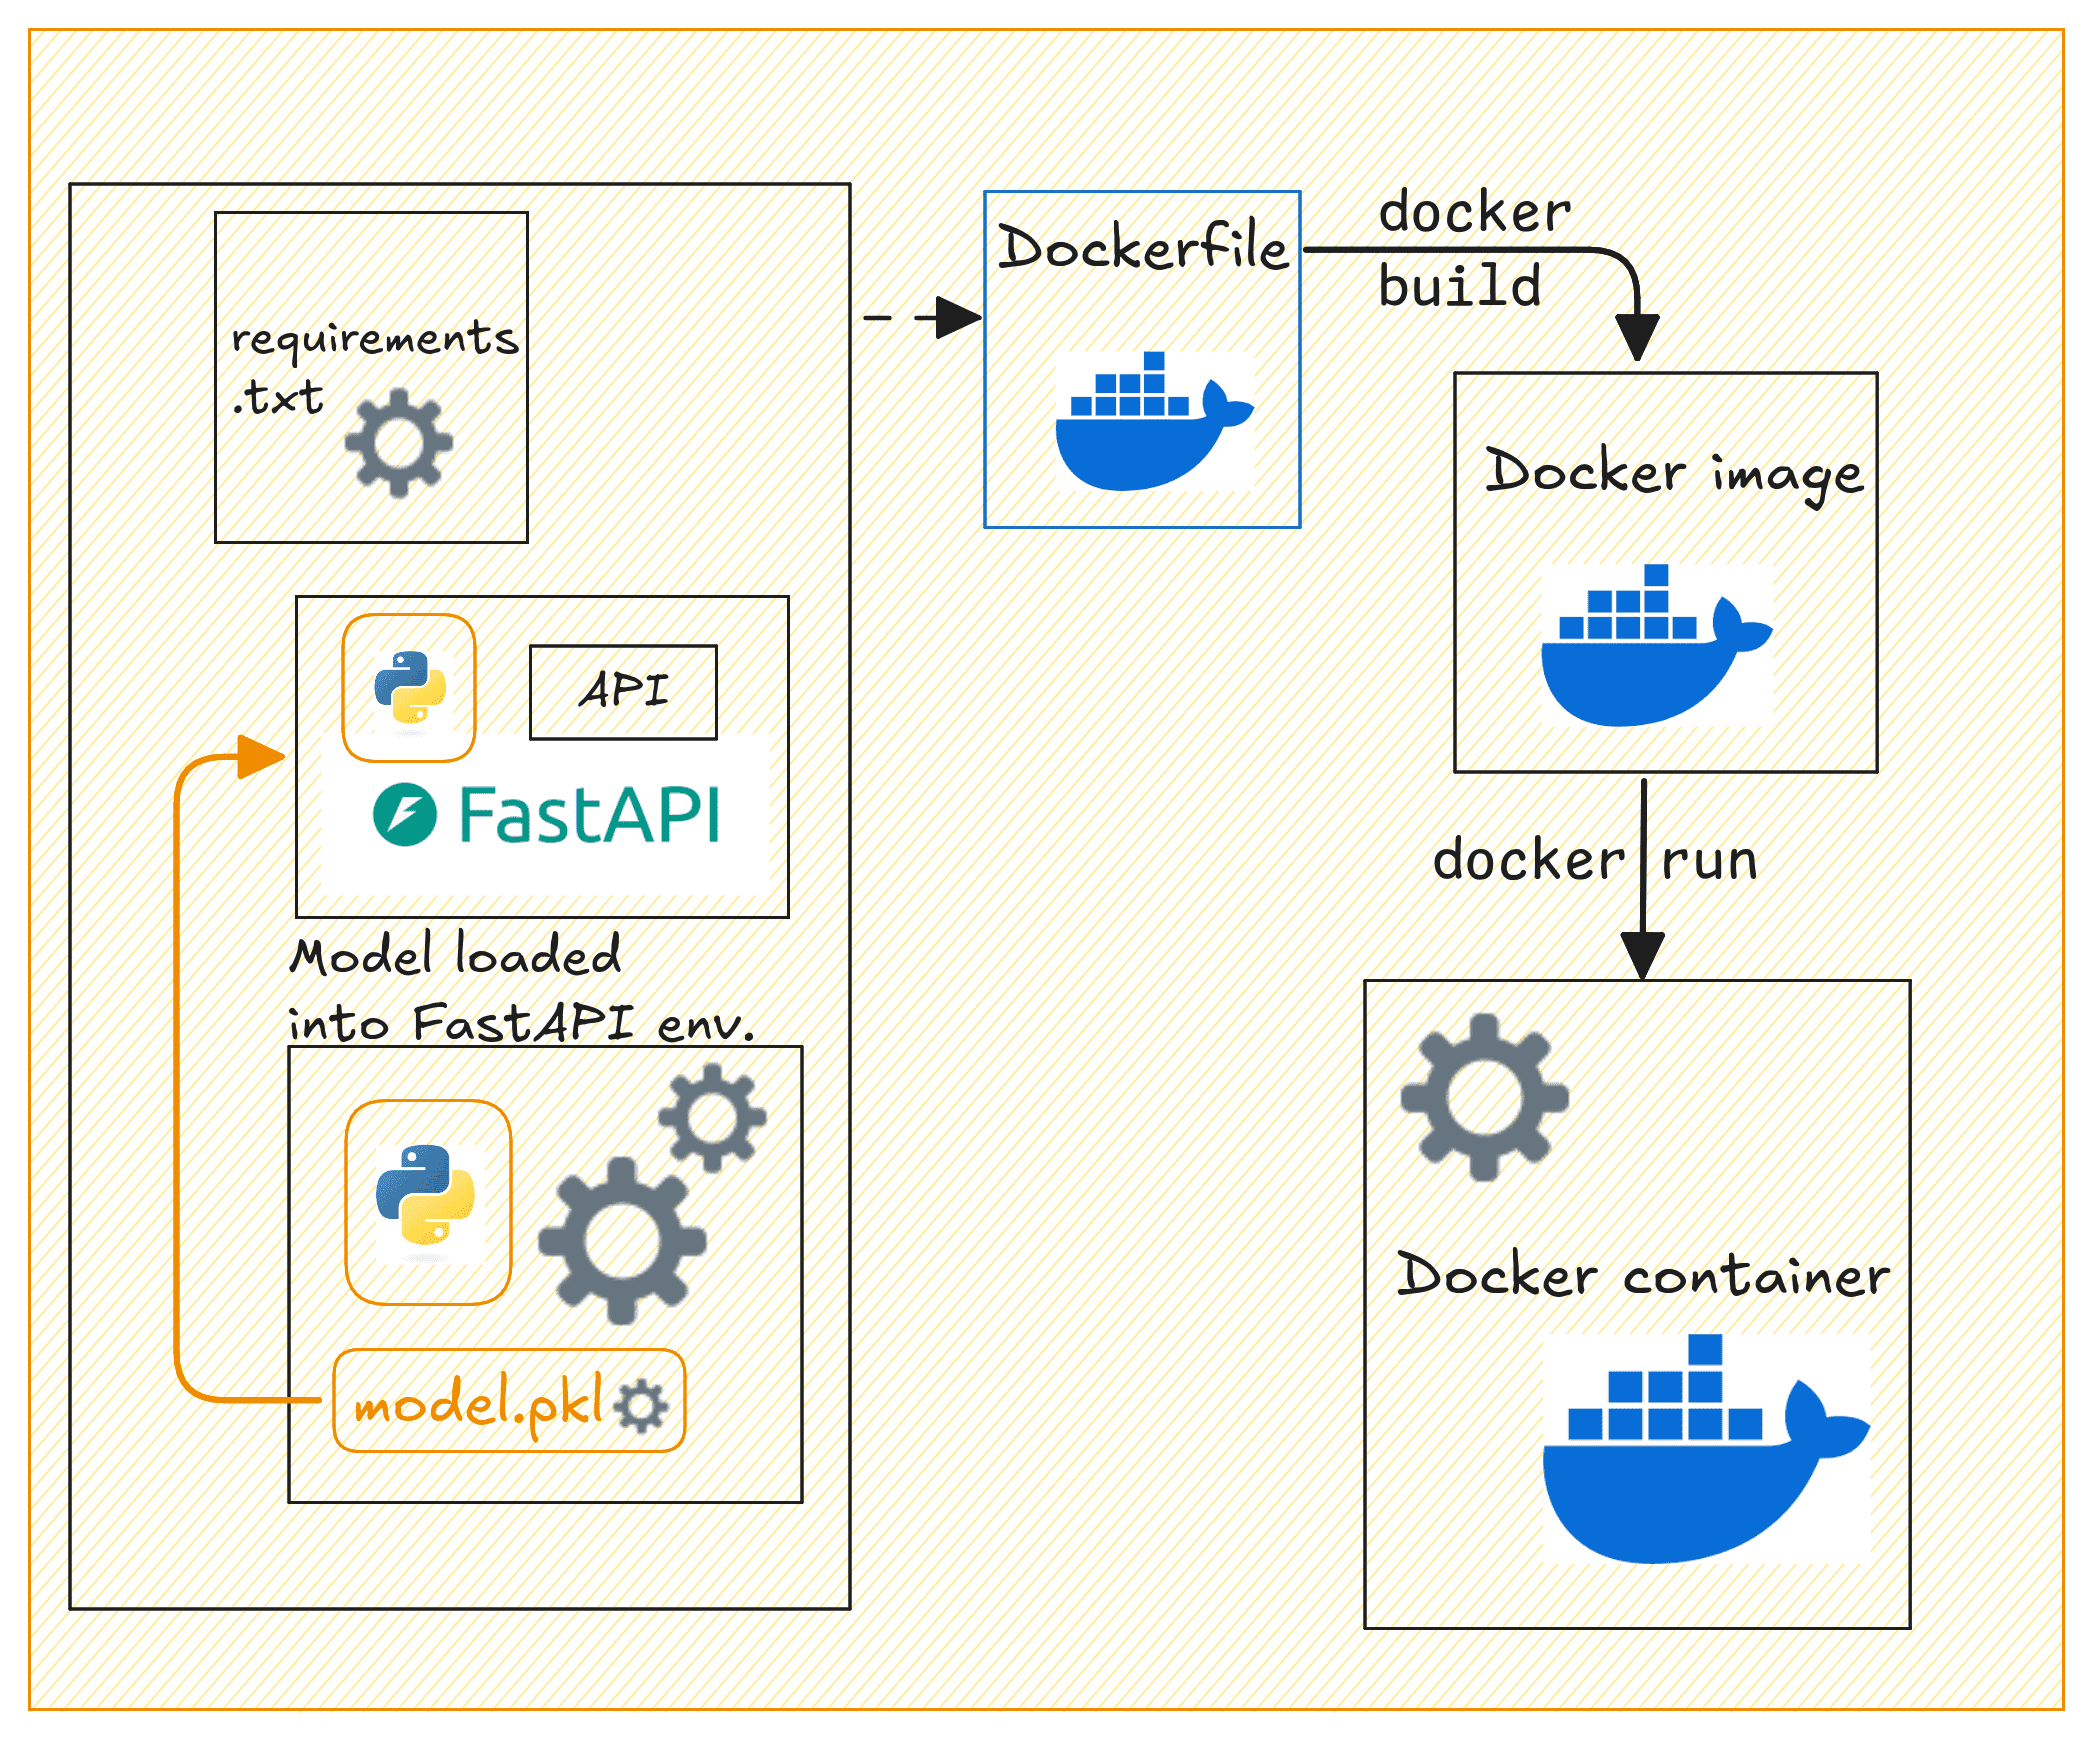

In [20]:
Image("./Appendix-files/figures/containerize-app1.png", width=550)

In [ ]:
$ docker build -t concrete-compress-prediction-api .

$ docker run -d -p 80:80 concrete-compress-prediction-api

#### 访问

In [ ]:
"""input_data = InputData(
    Cement=300.0,
    Blast_Furnace_Slag=100.0,
    Fly_Ash=50.0,
    Water=200.0,
    Superplasticizer=5.0,
    Coarse_Aggregate=1000.0,
    Fine_Aggregate=500.0,
    Age=28
)"""

In [ ]:
curl -X 'POST' \
  'http://127.0.0.1:80/predict' \
  -H 'Content-Type: application/json' \
  -d '{
  "Cement"=300.0,
  "Blast_Furnace_Slag"=100.0,
  "Fly_Ash"=50.0,
  "Water"=200.0,
  "Superplasticizer"=5.0,
  "Coarse_Aggregate"=1000.0,
  "Fine_Aggregate"=500.0,
  "Age"=28
}'